## What is Sentiment Analysis?

Sentiment Analysis is a field of Natural Language Processing responsible for systems that can extract opinions from natural language. NLP targets creating pipelines that can understand language like we humans do. Sentiment analysis is one of the most basic problems in NLP and is usually one of the first problem that students face in a Natural Language Processing domain.

## Why Sentiment Analysis?

From being able to mine opinions from product reviews to being able to forecast stock prices by studying tweets, sentiment analysis has a very wide range of applications. Sentiment Analysis forms the basis for almost every other pipeline in what we call Natural Language Understanding, due to the intuitive nature of the problem.<br>
From an learning point of view, sentiment analysis contains everything that a Data Scientist working in NLP should be aware of. Sentence processing and all the common models/architectures used in NLP can be covered under the umbrella of Sentiment Analysis.<br><br>
**Types of Sentiment Analysis**<br><br>

Sentiment Analysis is essentially a classification problem. While sentiment analysis contains a wide array of problem variety, the most common types can be broadly divided as,
- Polarity Detection : Talking about the polarity of the sentence, that is, positive, negative or neutral. Sometimes the classification can be even more fine tuned, like very positive, positive, neutral, negative and very negative.
- Emotion Detection : Detecting the emotion of the speaker from the sentence, for example, happy, sad, angry etc.
- Intent Detection : Being able to detect not only what is present in the sentence but also its intent.

We will perform Sentiment Analysis using deep learning technique incorporating Word Embeddings as illustrated below.


## Importing the essential(s)

In [50]:
#Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

#Visualization libraries
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import helper
from nltk.corpus import stopwords

Time for `keras` related import(s)

In [51]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

## Word Embeddings

When applying one-hot encoding(count vectorization) to the words in the tweets, we end up with sparse vectors of high dimensionality (here the number of words). On larger data sets this could cause performance issues. Additionally, one-hot encoding does not take into account the semantics of the words. For instance, _food_ and _meal_ are different words but have a similar meaning.

Word embeddings reduce these two issues. Word embeddings are dense vectors with a much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.

In [49]:
#Setting the hyperparameters

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 29  # Maximum number of words in a sequence

## Defining the Functions

In [9]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

## Load the Data

We will use Figure-8 dataset in this case.

In [10]:
import helper
data_dir = 'data/text_emotion.csv'
old_data = pd.read_csv(data_dir)

## Data Preparation

### Reading and cleaning the data

In [11]:
#Shuffling the dataset on its index
old_data = old_data.reindex(np.random.permutation(old_data.index))

In [12]:
#Displaying first 5 rows of the dataset
old_data.head()

,tweet_id,sentiment,author,content
35940,1753216045,sadness,VinoCW,"aww thats wikid, i need to book myne again soo..."
28504,1696219153,happiness,anniemare,@timhahnproject Heh. When I moved into my hou...
29498,1751249952,worry,herlastdownfall,happy mom's day. i haven't bought a present f...
34497,1752894621,happiness,courtney167,"playing guitar hero, waiting for Abby to text ..."
8425,1962176377,sadness,_HarryKim,@Orion_Girl OOC sorry we keep missing each oth...


In [13]:
old_data.shape

(40000, 4)

In [14]:
old_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 35940 to 12084
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


**Observation**

- As seen above, the dataset has 40K rows aka observations/records and 4 columns aka features.
- If we take a close look at `old_data.info()` output, it is evident that the 4 columns are `tweet_id`, `sentiment`, `author` and `content` each containing 40K records. Hence, we can infer that there are no null elements in the dataset.

Since `author` feature won't play a part in predicting sentiment from the content, we can drop that column. Alternatively, we can create a new dataframe with the required features like below:<br>
```python
data = data[['tweet_id', 'sentiment', 'content']]
```

In [15]:
data = old_data.drop('author', axis = 1)

Let's explore the `sentiment` feature!

In [16]:
data['sentiment'].nunique()

13

In [17]:
data['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

From the above, we can conclude that there are 13 unique sentiments listed in the dataset. Let us only consider the records having sentiment(s) as _happiness_ and _sadness_ only for simplicity purpose.<br><br>

If we have to drop the records with other sentiment labels, we can do it in the following ways:<br>

**Method 1**

We can drop rows with rest of the sentiment labels individually like below:

```python
old_data  = old_data.drop(data[data.sentiment == 'anger'].index)
old_data  = old_data.drop(data[data.sentiment == 'boredom'].index)
old_data  = old_data.drop(data[data.sentiment == 'enthusiasm'].index)
old_data  = old_data.drop(data[data.sentiment == 'empty'].index)
old_data  = old_data.drop(data[data.sentiment == 'fun'].index)
old_data  = old_data.drop(data[data.sentiment == 'relief'].index)
old_data  = old_data.drop(data[data.sentiment == 'surprise'].index)
old_data  = old_data.drop(data[data.sentiment == 'love'].index)
old_data  = old_data.drop(data[data.sentiment == 'hate'].index)
old_data  = old_data.drop(data[data.sentiment == 'neutral'].index)
old_data  = old_data.drop(data[data.sentiment == 'worry'].index)
```
**Method 2**

Since we will be deleting rows based on sentiments, what we can do is set `sentiment` feature as index and then drop the records as shown below, followed by re-setting the index,

```python
#If we want to set a particular feature/column as the index while loading the dataset
# old_data = pd.read_csv('data/text_emotion.csv', index_col ="sentiment" )
old_data.set_index('sentiment')

#Drop the records with rest of the sentiment labels
old_data = old_data.drop(["empty" , "neutral" ,"love", "surprise", "fun",
              "relief", "hate", "enthusiasm", "boredom", "anger", "worry"], inplace = True)

#Re-setting the index
old_data.reset_index()
```


But, let's not delete the records instead create a new dataframe `data` with the required `sentiment` labels.

In [18]:
data = data[data['sentiment'].isin(['happiness','sadness'])]

In [19]:
data.shape

(10374, 3)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10374 entries, 35940 to 12084
Data columns (total 3 columns):
tweet_id     10374 non-null int64
sentiment    10374 non-null object
content      10374 non-null object
dtypes: int64(1), object(2)
memory usage: 324.2+ KB


In [21]:
data['sentiment'].nunique()

2

In [22]:
data['sentiment'].value_counts()

happiness    5209
sadness      5165
Name: sentiment, dtype: int64

In [23]:
#To view each sentiment in %
data['sentiment'].value_counts(normalize = True)

happiness    0.502121
sadness      0.497879
Name: sentiment, dtype: float64

<IPython.core.display.Javascript object>


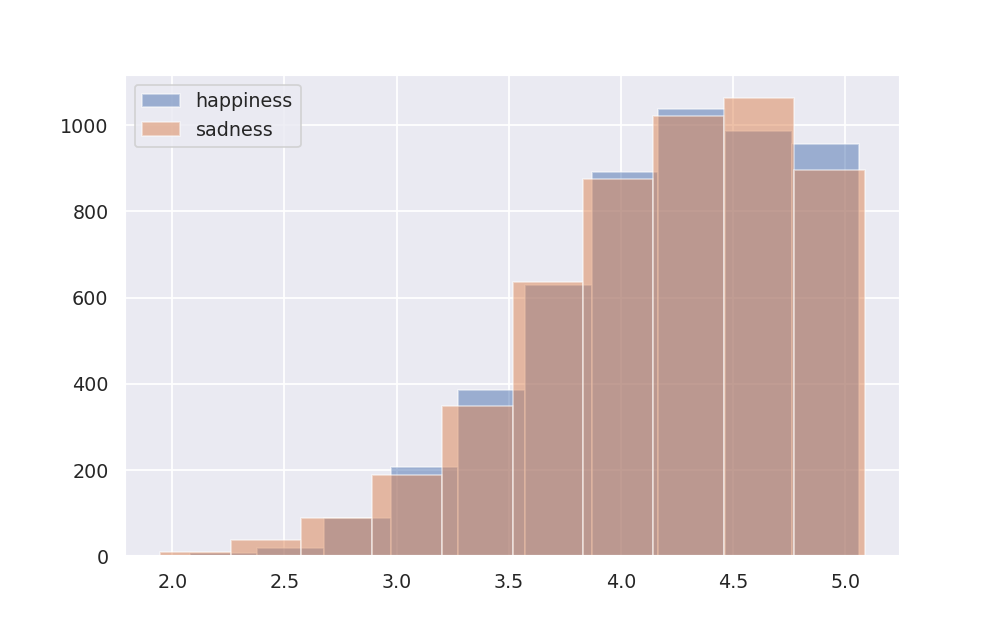

In [24]:
data.loc[data['sentiment'] == 'happiness', 'content'].str.len().apply(np.log1p).hist(label = 'happiness', alpha = .5)
data.loc[data['sentiment'] == 'sadness', 'content'].str.len().apply(np.log1p).hist(label = 'sadness', alpha = .5)
plt.legend();

Hence, we have created a new dataframe with only two sentiments - _happiness_, _sadness_.<br>

**Observation**

- The dataset is nearly balanced with almost equal number of _happiness_ and _sadness_ records.
- The distribution of lengths for _happiness_ and _sadness_ contents is also almost the same.

While recent Deep Learning models have promoted shifting all feature engineering to these models, NLP practitioners still prefer cleaning up the input before passing it through any pipeline.

When we take a look at the `content` feature of our dataset, we can see that there are a lot of stop words(auxiliary verbs, prepositions, @mentions which we need to eliminate.

In [25]:
#Removing stop words, @mentions
data.content = data.content.apply(remove_stopwords).apply(remove_mentions)

In [26]:
#Verifying the same
data.head()

,tweet_id,sentiment,content
35940,1753216045,sadness,"aww thats wikid, need book myne sooon miss lov..."
28504,1696219153,happiness,"Heh. When moved house Pius pep rally, cheerin..."
34497,1752894621,happiness,"playing guitar hero, waiting Abby text prom"
8425,1962176377,sadness,OOC sorry keep missing other...
6930,1961490023,sadness,Will miss baby days


### Splitting the dataset into train and test

Our data didn't come with separate training and test dataset(s), hence we will split our data into the same. Input to the model is `content` feature, while `sentiment` is the target variable.

In [27]:
#Splitting into train and test data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.content, data.sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 9336
# Test data samples: 1038


### Converting words to numbers

In [28]:

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

### Creating word sequences of equal length

Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) tweets.

In [29]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    9336.000000
mean        8.660133
std         4.217806
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        29.000000
Name: content, dtype: float64

Based on the figures above we will set MAX_LEN to 29. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

### Padding

In [30]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [31]:
# Example of padded sequence
X_train_seq_trunc[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  469,   11,
          4,  106, 1005,   67,   35,   25, 1073], dtype=int32)

### Converting the target classes to numbers

Our goal is to predict the sentiment from the given content. Henceforth, we will pick `sentiment` as our output label.<br><br>
Also, we can’t have text in our data if we’re going to run any kind of model on it. So before we can run a model, we need to make this data ready for the model.<br>
To convert categorical text data into model-understandable numerical data, we will use the `Label Encoder` class. The preference for `Label Encoder` over `One Hot Encoder` is purely because of the fact that we just have two labels(_happiness_ and _sadness_). In order to label encode the `sentiment` column, all we have to do is to import the `LabelEncoder` class from the `sklearn` library, fit and transform the `sentiment` column of the data, and then replace the existing text data with the new encoded data.<br><br>


In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Splitting off validation data

In [36]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (934, 29)


## Modeling

### Training word embeddings

Keras provides an Embedding layer which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors.

In [37]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='sigmoid'))
emb_model.summary()

W0811 23:39:19.419442 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 23:39:19.477663 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 23:39:19.479709 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 232)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 466       
Total params: 80,466
Trainable params: 80,466
Non-trainable params: 0
_________________________________________________________________


In [38]:

emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['acc'][-1]

W0811 23:39:28.053832 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 23:39:28.115529 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 23:39:28.403684 140653043123968 deprecation.py:323] From /home/rwamit/anaconda3/envs/dlprojects/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 23:39:28.609750 140653043123968 deprecation_wrapper.py:119] From /home/rwamit/anaconda3/envs/dlpr

0.8558676500486153


We have a validation accuracy of about 86%. The number of words in the tweets is rather low, so this result is rather good.
By comparing the training and validation accuracy and loss, we see that the model starts overfitting from epoch 5.

<IPython.core.display.Javascript object>


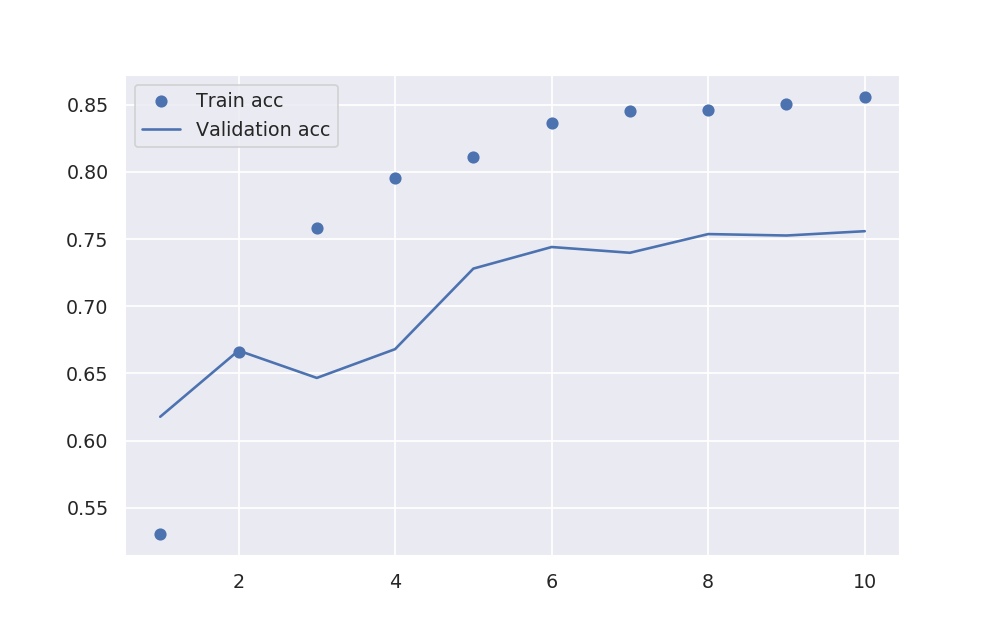

In [46]:
#Calculating Accuracy
%matplotlib notebook
eval_metric(emb_history, 'acc')

<IPython.core.display.Javascript object>


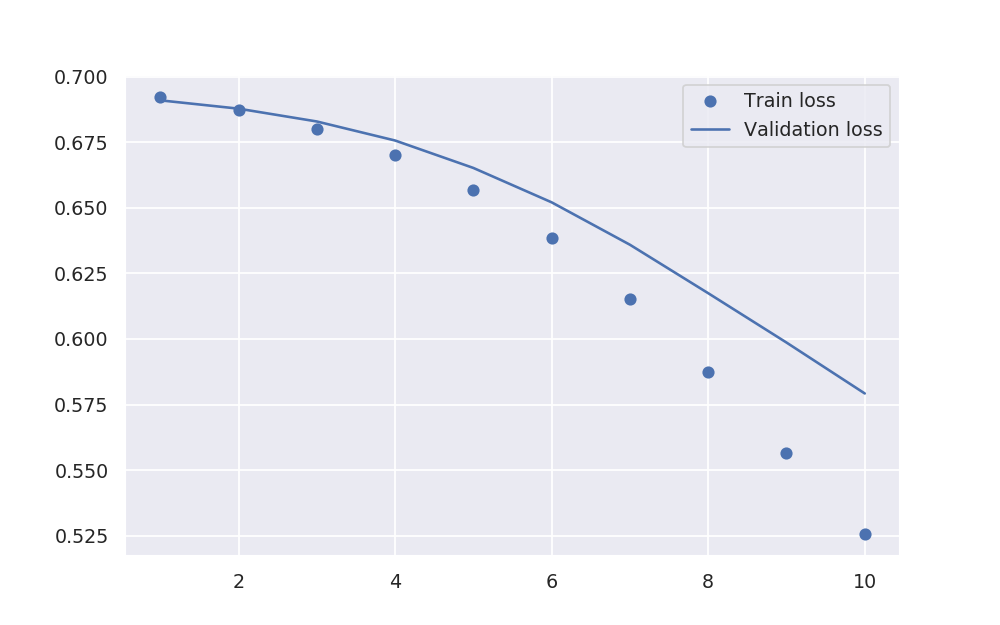

In [47]:
#Calculating Loss
%matplotlib notebook
eval_metric(emb_history, 'loss')

In [48]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1038/1038 [==============================] - 0s 90us/step
/n
Test accuracy of word embeddings model: 78.71%


## Conclusion

We have now obtained test accuracy of 78.71% . One reason for the deep learning model to not perform better than machine learning models is the size of the dataset. The dataset is quite small in order to be trained using deep learning model.